# Wikipedia functions and analysis
By [Brian Keegan](http://www.brianckeegan.com)  
November 2018  
Released under an MIT License

These notebooks are adaptations from a 5 session mini course at the University of Colorado. The github repo can be found here [Spring 2023 ITSS Mini-Course] The course is taught by Brian C. Keegan, Ph.D. Assistant Professor, Department of Information Science. They have been adapted for relevant content and integration with Docker so that we all have the same environment. Professor Keegan suggests using a most recent version of Python which we have through our docker container.

This notebook is adapted from excellent notebooks in Dr. Cody Buntain's seminar on Social Media and Crisis Informatics as well as the PRAW documentation.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

from datetime import datetime
from bs4 import BeautifulSoup
from urllib.parse import unquote, quote
from copy import deepcopy

import networkx as nx

import requests, json, re

## Functions

### Revision history

In [2]:
def response_to_revisions(json_response):
    if type(json_response['query']['pages']) == dict:
        page_id = list(json_response['query']['pages'].keys())[0]
        return json_response['query']['pages'][page_id]['revisions']
    elif type(json_response['query']['pages']) == list:
        return json_response['query']['pages'][0]['revisions']
    else:
        raise ValueError("There are no revisions in the JSON")

In [3]:
def get_page_revisions(page_title,endpoint='en.wikipedia.org/w/api.php',redirects=1):
    """Takes Wikipedia page title and returns a DataFrame of revisions
    
    page_title - a string with the title of the page on Wikipedia
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - a Boolean value for whether to follow redirects to another page
        
    Returns:
    df - a pandas DataFrame where each row is a revision and columns correspond
         to meta-data such as parentid, revid, sha1, size, timestamp, and user name
    """
    
    # A container to store all the revisions
    revision_list = list()
    
    # Set up the query
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'query'
    query_params['titles'] = page_title
    query_params['prop'] = 'revisions'
    query_params['rvprop'] = 'ids|userid|comment|timestamp|user|size|sha1'
    query_params['rvlimit'] = 500
    query_params['rvdir'] = 'newer'
    query_params['format'] = 'json'
    query_params['redirects'] = redirects
    query_params['formatversion'] = 2
    
    # Make the query
    json_response = requests.get(url = query_url, params = query_params).json()

    # Add the temporary list to the parent list
    revision_list += response_to_revisions(json_response)

    # Loop for the rest of the revisions
    while True:

        # Newer versions of the API return paginated results this way
        if 'continue' in json_response:
            query_continue_params = deepcopy(query_params)
            query_continue_params['rvcontinue'] = json_response['continue']['rvcontinue']
            json_response = requests.get(url = query_url, params = query_continue_params).json()
            revision_list += response_to_revisions(json_response)
        
        # Older versions of the API return paginated results this way
        elif 'query-continue' in json_response:
            query_continue_params = deepcopy(query_params)
            query_continue_params['rvstartid'] = json_response['query-continue']['revisions']['rvstartid']
            json_response = requests.get(url = query_url, params = query_continue_params).json()
            revision_list += response_to_revisions(json_response)
        
        # If there are no more revisions, stop
        else:
            break

    # Convert to a DataFrame
    df = pd.DataFrame(revision_list)

    # Add in some helpful fields to the DataFrame
    df['page'] = page_title
    df['userid'] = df['userid'].fillna(0).apply(lambda x:str(int(x)))
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].apply(lambda x:x.date())
    df['diff'] = df['size'].diff()
    df['lag'] = df['timestamp'].diff()/pd.Timedelta(1,'s')
    df['age'] = (df['timestamp'] - df['timestamp'].min())/pd.Timedelta(1,'d')

    return df

### Wiki-links

In [4]:
def parse_to_links(json_response):
    # Initialize an empty list to store the links
    outlinks_list = []
    
    page_html = json_response['parse']['text']#['*']

    # Parse the HTML into Beautiful Soup
    soup = BeautifulSoup(page_html,'lxml')

    # Remove sections at end
    bad_sections = ['See_also','Notes','References','Bibliography','External_links']
    bad_titles = ['Special:','Wikipedia:','Help:','Template:','Category:','International Standard','Portal:','s:','File:','Digital object identifier','(page does not exist)']
    
    sections = soup.find_all('h2')
    for section in sections:
        if section.span['id'] in bad_sections:

            # Clean out the divs
            div_siblings = section.find_next_siblings('div')
            for sibling in div_siblings:
                sibling.clear()

            # Clean out the ULs
            ul_siblings = section.find_next_siblings('ul')
            for sibling in ul_siblings:
                sibling.clear()

    # Delete tags associated with templates
    for tag in soup.find_all('tr'):
        tag.replace_with('')

    # For each paragraph tag, extract the titles within the links
    for para in soup.find_all('p'):
        for link in para.find_all('a'):
            if link.has_attr('title'):
                title = link['title']
                # Ignore links that aren't interesting or are redlinks
                if all(bad not in title for bad in bad_titles) and 'redlink' not in link['href']:
                    outlinks_list.append(title)

    # For each unordered list, extract the titles within the child links
    for unordered_list in soup.find_all('ul'):
        for item in unordered_list.find_all('li'):
            for link in item.find_all('a'):
                if link.has_attr('title'):
                    title = link['title']
                    # Ignore links that aren't interesting or are redlinks
                    if all(bad not in title for bad in bad_titles) and 'redlink' not in link['href']:
                        outlinks_list.append(title)
    
    return outlinks_list

In [5]:
def get_page_outlinks(page_title,endpoint='en.wikipedia.org/w/api.php',redirects=1):
    """Takes a page title and returns a list of wiki-links on the page. The 
    list may contain duplicates and the position in the list is approximately 
    where the links occurred.
    
    page_title - a string with the title of the page on Wikipedia
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
    
    Returns:
    outlinks_per_lang - a dictionary keyed by language returning a dictionary 
        keyed by page title returning a list of outlinks
    """
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    #req = requests.get('https://{2}.wikipedia.org/w/api.php?action=parse&format=json&page={0}&redirects={1}&prop=text&disableeditsection=1&disabletoc=1'.format(page_title,redirects,lang))
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'parse'
    query_params['page'] = page_title
    query_params['redirects'] = redirects
    query_params['prop'] = 'text'
    query_params['disableeditsection'] = 1
    query_params['disabletoc'] = 1
    query_params['format'] = 'json'
    query_params['formatversion'] = 2
    
    json_response = requests.get(url = query_url, params = query_params,headers={'user-agent':'langholz@g.ucla.edu'}).json()
    
    if 'parse' in json_response.keys():
        return parse_to_links(json_response)
    

In [6]:
def get_revision_outlinks(revid,endpoint='en.wikipedia.org/w/api.php',redirects=1):
    """Takes a page title and returns a list of wiki-links on the page. The 
    list may contain duplicates and the position in the list is approximately 
    where the links occurred.
    
    page_title - a string with the title of the page on Wikipedia
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
    
    Returns:
    outlinks_per_lang - a dictionary keyed by language returning a dictionary 
        keyed by page title returning a list of outlinks
    """
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    #req = requests.get('https://{2}.wikipedia.org/w/api.php?action=parse&format=json&page={0}&redirects={1}&prop=text&disableeditsection=1&disabletoc=1'.format(page_title,redirects,lang))
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'parse'
    query_params['oldid'] = revid
    query_params['prop'] = 'text'
    query_params['disableeditsection'] = 1
    query_params['disabletoc'] = 1
    query_params['format'] = 'json'
    query_params['formatversion'] = 2
    
    json_response = requests.get(url = query_url, params = query_params,headers={'user-agent':'langholz@g.ucla.edu'}).json()
    
    if 'parse' in json_response.keys():
        return parse_to_links(json_response)
    

### External links

In [7]:
def get_page_externallinks(page_title,endpoint='en.wikipedia.org/w/api.php',redirects=1):
    """Takes a revision id and returns a list of external links on the revision
    
    revid - a numeric revision id as a string
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
    parse - 1 or 0 for whether to return the raw HTML or paragraph text
    
    Returns:
    str - a list of strings with the URLs
    """
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    # req = requests.get('https://{2}.wikipedia.org/w/api.php?action=parse&format=json&oldid={0}&redirects={1}&prop=externallinks&disableeditsection=1&disabletoc=1'.format(revid,redirects,lang))
    
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'parse'
    query_params['page'] = page_title
    query_params['redirects'] = redirects
    query_params['prop'] = 'externallinks'
    query_params['disableeditsection'] = 1
    query_params['disabletoc'] = 1
    query_params['format'] = 'json'
    query_params['formatversion'] = 2
    
    json_response = requests.get(url = query_url, params = query_params).json()
    
    if 'parse' in json_response.keys():
        if 'externallinks' in json_response['parse']:
            return json_response['parse']['externallinks']
        

In [8]:
def get_revision_externallinks(revid,endpoint='en.wikipedia.org/w/api.php',redirects=1):
    """Takes a revision id and returns a list of external links on the revision
    
    revid - a numeric revision id as a string
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
    parse - 1 or 0 for whether to return the raw HTML or paragraph text
    
    Returns:
    str - a list of strings with the URLs
    """
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    # req = requests.get('https://{2}.wikipedia.org/w/api.php?action=parse&format=json&oldid={0}&redirects={1}&prop=externallinks&disableeditsection=1&disabletoc=1'.format(revid,redirects,lang))
    
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'parse'
    query_params['oldid'] = revid
    query_params['prop'] = 'externallinks'
    query_params['disableeditsection'] = 1
    query_params['disabletoc'] = 1
    query_params['format'] = 'json'
    query_params['formatversion'] = 2
    
    json_response = requests.get(url = query_url, params = query_params).json()
    
    if 'parse' in json_response.keys():
        if 'externallinks' in json_response['parse']:
            return json_response['parse']['externallinks']
        

### Page content

In [9]:
def parse_to_text(json_response,parsed_text):
    page_html = json_response['parse']['text']#['*']
    
    # Parse the HTML into Beautiful Soup
    soup = BeautifulSoup(page_html,'lxml')

    # Remove sections at end
    bad_sections = ['See_also','Notes','References','Bibliography','External_links']
    sections = soup.find_all('h2')
    for section in sections:
        if section.span['id'] in bad_sections:

            # Clean out the divs
            div_siblings = section.find_next_siblings('div')
            for sibling in div_siblings:
                sibling.clear()

            # Clean out the ULs
            ul_siblings = section.find_next_siblings('ul')
            for sibling in ul_siblings:
                sibling.clear()

    # Get all the paragraphs
    paras = soup.find_all('p')

    text_list = []

    for para in paras:
        if parsed_text:
            _s = para.text
            # Remove the citations
            _s = re.sub(r'\[[0-9]+\]','',_s)
            text_list.append(_s)
        else:
            text_list.append(str(para))

    return '\n'.join(text_list)

In [10]:
def get_page_content(page_title,endpoint='en.wikipedia.org/w/api.php',redirects=1,parsed_text=1):
    """Takes a page_title and returns a (large) string of the content 
    of the revision.
    
    page_title - a string with the title of the page on Wikipedia
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
    parse - 1 to return plain text or 0 to return raw HTML
    
    Returns:
    str - a (large) string of the content of the revision
    """
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'parse'
    query_params['page'] = page_title
    query_params['redirects'] = redirects
    query_params['prop'] = 'text'
    query_params['disableeditsection'] = 1
    query_params['disabletoc'] = 1
    query_params['format'] = 'json'
    query_params['formatversion'] = 2
    
    json_response = requests.get(url = query_url, params = query_params,headers={'user-agent':'langholz@g.ucla.edu'}).json()
    
    if 'parse' in json_response.keys():
        return parse_to_text(json_response,parsed_text)
    

In [11]:
def get_revision_content(revid,endpoint='en.wikipedia.org/w/api.php',parsed_text=1):
    """Takes a page_title and returns a (large) string of the content 
    of the revision.
    
    revid - the revision ID of a revision on a wiki project
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
    parse - 1 to return plain text or 0 to return raw HTML
    
    Returns:
    str - a (large) string of the content of the revision
    """
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'parse'
    query_params['oldid'] = revid
    query_params['prop'] = 'text'
    query_params['disableeditsection'] = 1
    query_params['disabletoc'] = 1
    query_params['format'] = 'json'
    query_params['formatversion'] = 2
    
    json_response = requests.get(url = query_url, params = query_params).json()
    
    if 'parse' in json_response.keys():
        return parse_to_text(json_response,parsed_text)
    

### Inter-language links

In [12]:
def get_interlanguage_links(page_title,endpoint='en.wikipedia.org/w/api.php',redirects=1):
    """The function accepts a page_title and returns a dictionary containing 
    the title of the page in its other languages
       
    page_title - a string with the title of the page on Wikipedia
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
       
    Returns:
    langlink_dict - a dictionary keyed by lang codes and page title as values
    """
    
    #query_string = "https://{1}.wikipedia.org/w/api.php?action=query&format=json&prop=langlinks&formatversion=2&titles={0}&llprop=autonym|langname&lllimit=500".format(page_title,lang)
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'query'
    query_params['prop'] = 'langlinks'
    query_params['titles'] = page_title
    query_params['redirects'] = redirects
    query_params['llprop'] = 'autonym|langname'
    query_params['lllimit'] = 500
    query_params['format'] = 'json'
    query_params['formatversion'] = 2
    json_response = requests.get(url=query_url,params=query_params).json()
    
    interlanguage_link_dict = dict()
    interlanguage_link_dict['en'] = page_title

    if 'langlinks' in json_response['query']['pages'][0]:
        langlink_dict = json_response['query']['pages'][0]['langlinks']

        for d in langlink_dict:
            lang = d['lang']
            title = d['title']
            interlanguage_link_dict[lang] = title
            
    return interlanguage_link_dict

### Pageviews

Note that this code talks to a different API endpoint that the previous functions and will only work for Wikimedia projects (*e.g.*, Wikipedia) and not for other Media Wiki installations (*e.g.*, Wikia). Also note that this API returns no data from before July 1, 2015.

In [13]:
def get_pageviews(page_title,endpoint='en.wikipedia.org',date_from='20150701',date_to=str(datetime.today().date()).replace('-','')):
    """Takes Wikipedia page title and returns a all the various pageview records
    
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
        datefrom - a date string in a YYYYMMDD format, defaults to 20150701 (earliest date)
        dateto - a date string in a YYYYMMDD format, defaults to today
        
    Returns:
    df - a DataFrame indexed by date and multi-columned by agent and access type
    """
    quoted_page_title = quote(page_title, safe='')
    date_from = datetime.strftime(pd.to_datetime(date_from),'%Y%m%d')
    date_to = datetime.strftime(pd.to_datetime(date_to),'%Y%m%d')
    
    #for access in ['all-access','desktop','mobile-app','mobile-web']:
    #for agent in ['all-agents','user','spider','bot']:
    s = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{1}/{2}/{3}/{0}/daily/{4}/{5}".format(quoted_page_title,endpoint,'all-access','user',date_from,date_to)
    json_response = requests.get(s,headers={'user-agent':'langholz@g.ucla.edu'}).json()
    
    if 'items' in json_response:
        df = pd.DataFrame(json_response['items'])
    else:
        raise KeyError('There is no "items" key in the JSON response.')
        
    df = df[['timestamp','views']]
    df['timestamp'] = pd.to_datetime(df['timestamp'],format='%Y%m%d%H')
    s = df.set_index('timestamp')['views']
        
    return s

# Analyze the data

In [14]:
page1_title = 'Darth Vader'
page2_title = 'Anakin Skywalker'
page3_title = 'Luke Skywalker'

enwiki_endpoint = 'en.wikipedia.org/w/api.php'
starwars_endpoint = 'starwars.wikia.com/api.php'

## Comparing article revision dynamics

### Comparing articles

In [15]:
page1_rev_df = get_page_revisions(page1_title,endpoint=enwiki_endpoint)
page2_rev_df = get_page_revisions(page2_title,endpoint=starwars_endpoint)

Compare the number of revisions.

In [16]:
page1_rev_count = len(page1_rev_df)
page2_rev_count = len(page2_rev_df)

print("The '{0}' article has {1:,} revisions.".format(page1_title,page1_rev_count))
print("The '{0}' article has {1:,} revisions.".format(page2_title,page2_rev_count))

The 'Darth Vader' article has 15,964 revisions.
The 'Anakin Skywalker' article has 7,001 revisions.


Count the total number of unique users for each article.

In [17]:
page1_user_count = len(page1_rev_df['user'].unique())
page2_user_count = len(page2_rev_df['user'].unique())

print("The '{0}' article has {1:,} unique editors.".format(page1_title,page1_user_count))
print("The '{0}' article has {1:,} unique editors.".format(page2_title,page2_user_count))

The 'Darth Vader' article has 5,508 unique editors.
The 'Anakin Skywalker' article has 738 unique editors.


The first edit to the article.

In [18]:
page1_first_rev = min(page1_rev_df['date'])
page2_first_rev = min(page2_rev_df['date'])

print("The '{0}' article was first edited on {1:}.".format(page1_title,page1_first_rev))
print("The '{0}' article was first edited on {1:}.".format(page2_title,page2_first_rev))

The 'Darth Vader' article was first edited on 2002-05-27.
The 'Anakin Skywalker' article was first edited on 2014-05-23.


Plot out how the size of the articles have changed.

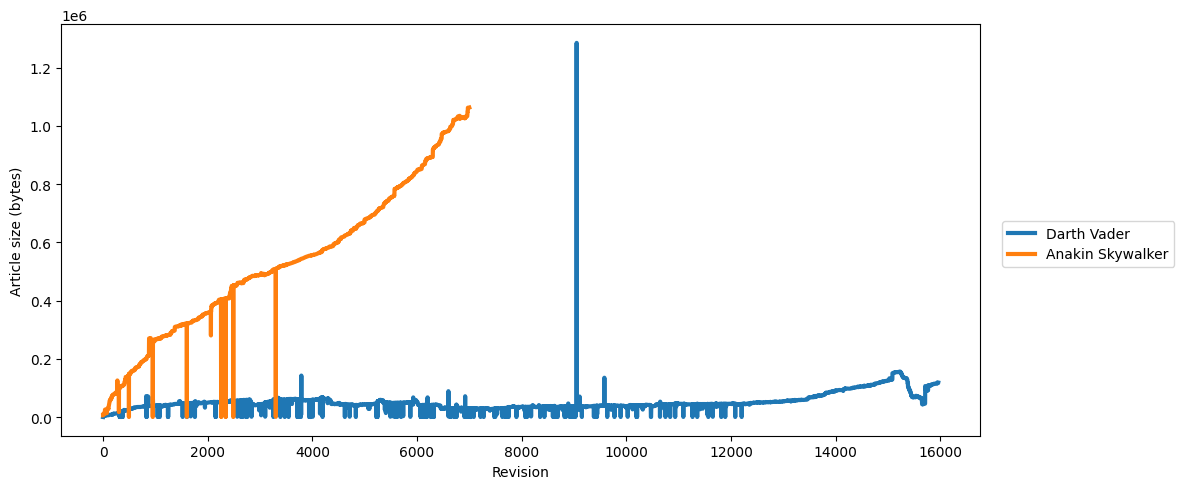

In [19]:
f,ax = plt.subplots(1,1,figsize=(10,5))

page1_rev_df['size'].plot(ax=ax,label=page1_title,lw=3)
page2_rev_df['size'].plot(ax=ax,label=page2_title,lw=3)

ax.set_xlabel('Revision')
ax.set_ylabel('Article size (bytes)')

f.legend(loc='center left',bbox_to_anchor=(1,.5))
f.tight_layout()

Now actually compute some daily statistics.

In [20]:
page1_rev_df.head()

,revid,parentid,user,userid,timestamp,size,sha1,comment,anon,commenthidden,userhidden,sha1hidden,suppressed,page,date,diff,lag,age
0,2641857,0,Mav,62,2002-05-27 22:54:59+00:00,30,15292eeeb6652215f50645dfdfa85fd3144465a2,#REDIRECT [[Anakin Skywalker]],NaN,NaN,NaN,NaN,NaN,Darth Vader,2002-05-27,NaN,NaN,0.000000
1,2670989,2641857,Texture,31280,2004-03-05 20:14:33+00:00,3528,4b5bfbbdb138f863a66cdc2b8b3a19e6668ecf9e,"Attempt to split, via cleanup",NaN,NaN,NaN,NaN,NaN,Darth Vader,2004-03-05,3498.0,55977574.0,647.888588
2,2671042,2670989,JEMcN,49727,2004-03-07 22:25:39+00:00,3532,2cdfce61bbc59744a6c9d0e895c2af59737fae8a,,NaN,NaN,NaN,NaN,NaN,Darth Vader,2004-03-07,4.0,180666.0,649.979630
3,2731270,2671042,JEMcN,49727,2004-03-07 22:28:55+00:00,3555,c95c09aad2e17ee65c0075c3d73fa36845bed1c6,,NaN,NaN,NaN,NaN,NaN,Darth Vader,2004-03-07,23.0,196.0,649.981898
4,2803586,2731270,Johnleemk,21916,2004-03-12 09:26:03+00:00,3606,4aa4954f77cdd21d1c5118e80bf836b85bac6ff1,,NaN,NaN,NaN,NaN,NaN,Darth Vader,2004-03-12,51.0,385028.0,654.438241


Make a function to help clean up the data.

In [21]:
def daily_activity_maker(agg_df):
    # Relabel columns
    agg_df.columns = ['size','editors','revisions']

    # Reindex to a continuous date range
    min_date, max_date = min(agg_df.index), max(agg_df.index)
    agg_df = agg_df.reindex(pd.date_range(min_date,max_date))

    # Missing values for users and revisions mean nothing happened that day
    agg_df.fillna({'editors':0,'revisions':0},inplace=True)

    # Missing values for size means the article was the same size as the day before
    agg_df['size'].fillna(method='ffill',inplace=True)
    return agg_df

In [22]:
# Define an aggregation dictionary
agg_d = {'size':np.median, # Median size per day
         'user':pd.Series.nunique, # Number of unique users per day
         'sha1':pd.Series.nunique  # Number of unique revisions per day
        }

# Group revisions by date and apply the agg_d
page1_agg_df = page1_rev_df.groupby('date').agg(agg_d)

# Clean up the agg_d to daily activity
page1_agg_df = daily_activity_maker(page1_agg_df)

# Repeat for the second page
page2_agg_df = page2_rev_df.groupby('date').agg(agg_d)
page2_agg_df = daily_activity_maker(page2_agg_df)

# Inspect one
page1_agg_df.tail()

/tmp/ipykernel_153/3168051160.py:8: FutureWarning: The provided callable <function median at 0x7f0ae43c2ca0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  page1_agg_df = page1_rev_df.groupby('date').agg(agg_d)
/tmp/ipykernel_153/2728528314.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg_df['size'].fillna(method='ffill',inplace=True)
/tmp/ipykernel_153/3168051160.py:14: FutureWarning: The provided callable <function median at 0x7f0ae43c2ca0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  page2_agg_df = page2_rev_df.groupby('date').agg(agg_d)
/tmp/ipykernel_153/2728528314.py:13: FutureWarning: Series.fillna with 'method' is deprecate

,size,editors,revisions
2025-04-15,118348.0,0.0,0.0
2025-04-16,118348.0,0.0,0.0
2025-04-17,118348.0,0.0,0.0
2025-04-18,118348.0,0.0,0.0
2025-04-19,118331.0,1.0,1.0


Plot out how the sizes of the articles have changed over time.

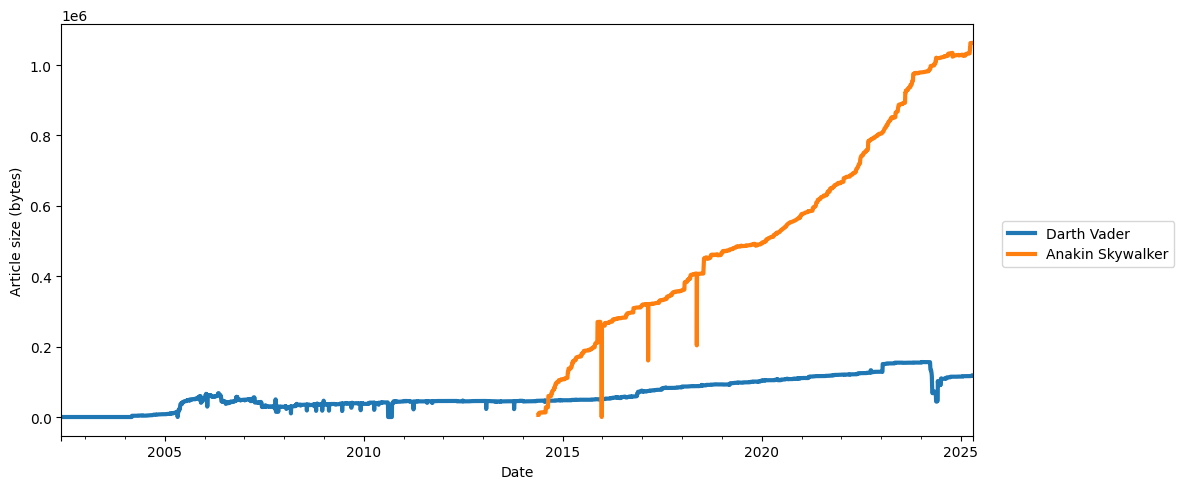

In [23]:
f,ax = plt.subplots(1,1,figsize=(10,5))

page1_agg_df['size'].plot(ax=ax,label=page1_title,lw=3)
page2_agg_df['size'].plot(ax=ax,label=page2_title,lw=3)

ax.set_xlabel('Date')
ax.set_ylabel('Article size (bytes)')

f.legend(loc='center left',bbox_to_anchor=(1,.5))
f.tight_layout()

Plot out how the number of editors has changed over time.

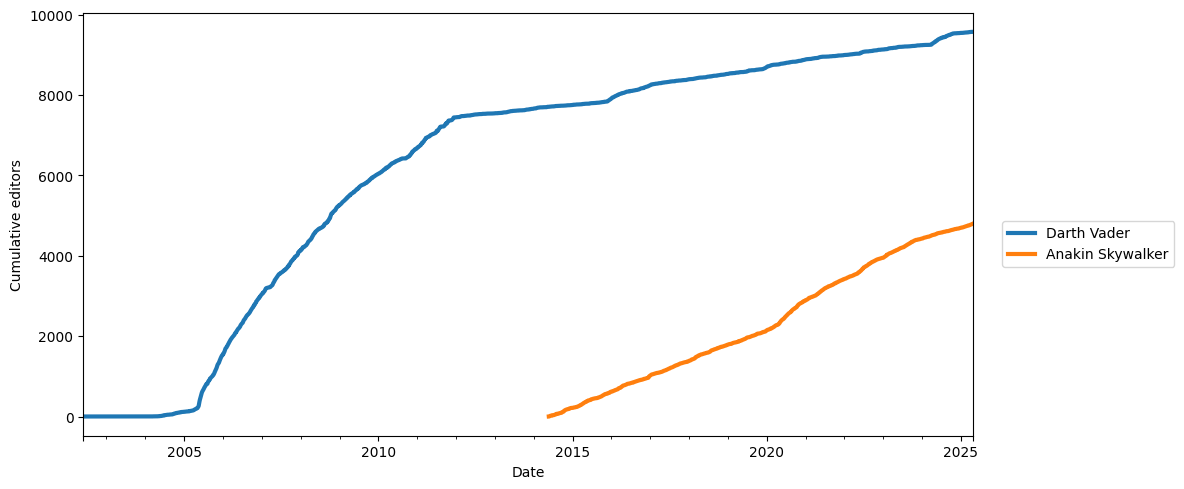

In [24]:
f,ax = plt.subplots(1,1,figsize=(10,5))

page1_agg_df['editors'].cumsum().plot(ax=ax,label=page1_title,lw=3)
page2_agg_df['editors'].cumsum().plot(ax=ax,label=page2_title,lw=3)

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative editors')

f.legend(loc='center left',bbox_to_anchor=(1,.5))
f.tight_layout()

Plot out the number of revisions per day with a rolling 28-day average.

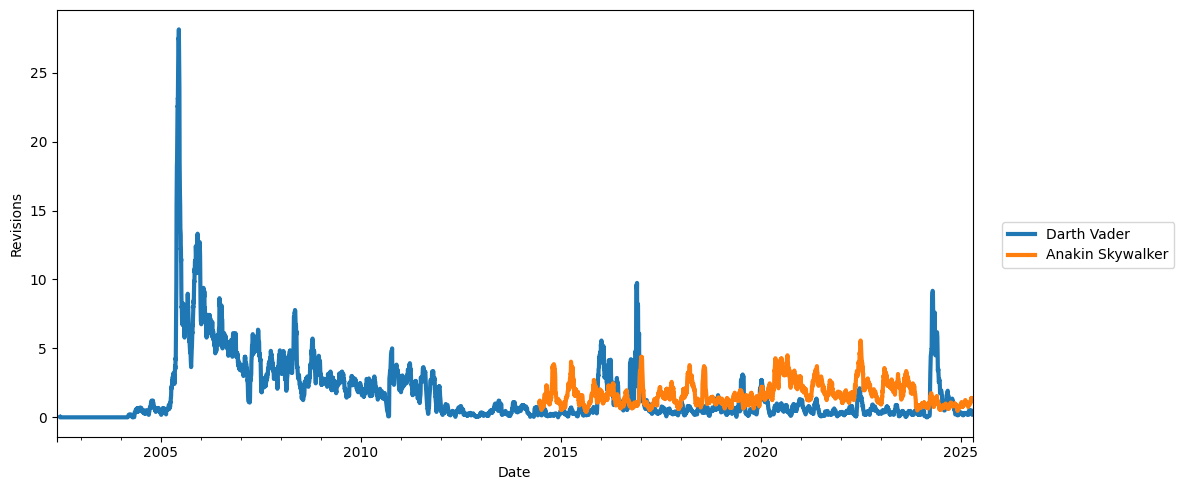

In [25]:
f,ax = plt.subplots(1,1,figsize=(10,5))

page1_agg_df['revisions'].rolling(28).mean().plot(ax=ax,label=page1_title,lw=3)
page2_agg_df['revisions'].rolling(28).mean().plot(ax=ax,label=page2_title,lw=3)

ax.set_xlabel('Date')
ax.set_ylabel('Revisions')

f.legend(loc='center left',bbox_to_anchor=(1,.5))
f.tight_layout()

### Comparing languages

The `get_interlanguage_links` will return a dictionary keyed by language code and valued by the Wikipedia article title in that language.

In [26]:
page1_ill = get_interlanguage_links(page1_title,endpoint='en.wikipedia.org/w/api.php')
page1_ill

{'en': 'Darth Vader',
 'ar': 'دارث فيدر',
 'ast': 'Darth Vader',
 'az': 'Dart Vayder',
 'bar': 'Darth Vader',
 'be': 'Дарт Вэйдэр',
 'be-x-old': 'Дарт Вэйдэр',
 'bg': 'Дарт Вейдър',
 'bh': 'डार्थ वेडर',
 'bn': 'ডার্থ ভেডার',
 'br': 'Dark Vador',
 'bs': 'Darth Vader',
 'ca': 'Darth Vader',
 'ceb': 'Darth Vader',
 'cs': 'Darth Vader',
 'cy': 'Darth Vader',
 'da': 'Darth Vader',
 'de': 'Darth Vader',
 'el': 'Νταρθ Βέιντερ',
 'eo': 'Darth Vader',
 'es': 'Darth Vader',
 'et': 'Darth Vader',
 'eu': 'Darth Vader',
 'fa': 'دارث ویدر',
 'fi': 'Darth Vader',
 'fr': 'Dark Vador',
 'fy': 'Darth Vader',
 'gl': 'Darth Vader',
 'ha': 'Darth Vader',
 'haw': 'Darth Vader',
 'he': "דארת' ויידר",
 'hi': 'डार्थ वेडर',
 'hr': 'Darth Vader',
 'hu': 'Darth Vader',
 'hy': 'Դարթ Վեյդեր',
 'ia': 'Darth Vader',
 'id': 'Darth Vader',
 'is': 'Svarthöfði',
 'it': 'Dart Fener',
 'ja': 'ダース・ベイダー',
 'ka': 'დართ ვეიდერი',
 'ko': '다스 베이더',
 'krc': 'Дарт Вейдер',
 'la': 'Darth Vader',
 'lmo': 'Dart Fener',
 'lt': 'Dartas

Translate links in other languages using the `get_interlanguage_links` and (hopefully!) finding the English article.

In [27]:
get_interlanguage_links('دارث فيدر',endpoint='ar.wikipedia.org/w/api.php')['en']

'Darth Vader'

Which means you can (potentially!) translate most of the links on other languages' pages back to English.

In [28]:
# Get all of the outlinks on the Arabic Darth Vader article, use set to remove duplicates
page1_ill_ar = set(get_page_outlinks('دارث فيدر',endpoint='ar.wikipedia.org/w/api.php'))

# For each link on the Arabic version of the article
for link in page1_ill_ar:
    # Get that link's inter-language links
    ill = get_interlanguage_links(link,endpoint='ar.wikipedia.org/w/api.php')
    
    # If there's an English version of the article, print out the Arabic and English
    if 'en' in ill.keys():
        print("'{0}' is Arabic for '{1}'".format(link,ill['en']))
        
    # Otherwise print there's no corresponding English link
    else:
        print("Wikipedia has no English link for '{0}'".format(link))

'بالباتين' is Arabic for 'Palpatine'
'بطل مأساوي' is Arabic for 'Tragic hero'
'هانيبال ليكتر' is Arabic for 'Hannibal Lecter'
'روج ون: قصة من حرب النجوم' is Arabic for 'Rogue One'
'حرب النجوم: القوة تنهض' is Arabic for 'Star Wars: The Force Awakens'
'كايلو رين' is Arabic for 'Kylo Ren'
'الأميرة ليا' is Arabic for 'Princess Leia'
'بوابة:عقد 1970' is Arabic for 'Portal:1970s'
'لوك سكاي ووكر' is Arabic for 'Luke Skywalker'
'بوابة:ديزني' is Arabic for 'Portal:Disney'
'نورمان بيتس' is Arabic for 'Norman Bates'
'معهد الفيلم الأمريكي 100 عام و100 بطل وشرير' is Arabic for 'AFI's 100 Years...100 Heroes & Villains'
'اللغة الإنجليزية' is Arabic for 'English language'
'بوابة:السينما الأمريكية' is Arabic for 'بوابة:السينما الأمريكية'
'بوابة:سينما' is Arabic for 'Portal:Film'
'جورج لوكاس' is Arabic for 'George Lucas'
'قاعدة بيانات الأفلام على الإنترنت' is Arabic for 'IMDb'
'بادمي أميدالا' is Arabic for 'Padmé Amidala'
'جيداي' is Arabic for 'Jedi'
'حرب النجوم' is Arabic for 'Star Wars'


Get the page revisions in other languages.

In [29]:
page1_title_ar = page1_ill['ar']
page1_title_pt = page1_ill['pt']
page1_title_zh = page1_ill['zh']

print("The name of '{0}' in Arabic is: '{1}'".format(page1_title,page1_title_ar))
print("The name of '{0}' in Portugese is: '{1}'".format(page1_title,page1_title_pt))
print("The name of '{0}' in Chinese is: '{1}'".format(page1_title,page1_title_zh))

page1_en_rev_df = get_page_revisions(page1_title,endpoint='en.wikipedia.org/w/api.php')
page1_ar_rev_df = get_page_revisions(page1_title_ar,endpoint='ar.wikipedia.org/w/api.php')
page1_pt_rev_df = get_page_revisions(page1_title_pt,endpoint='pt.wikipedia.org/w/api.php')
page1_zh_rev_df = get_page_revisions(page1_title_zh,endpoint='zh.wikipedia.org/w/api.php')

The name of 'Darth Vader' in Arabic is: 'دارث فيدر'
The name of 'Darth Vader' in Portugese is: 'Darth Vader'
The name of 'Darth Vader' in Chinese is: '達斯·維達'


Plot out how the size of the articles have changed based on each revision.

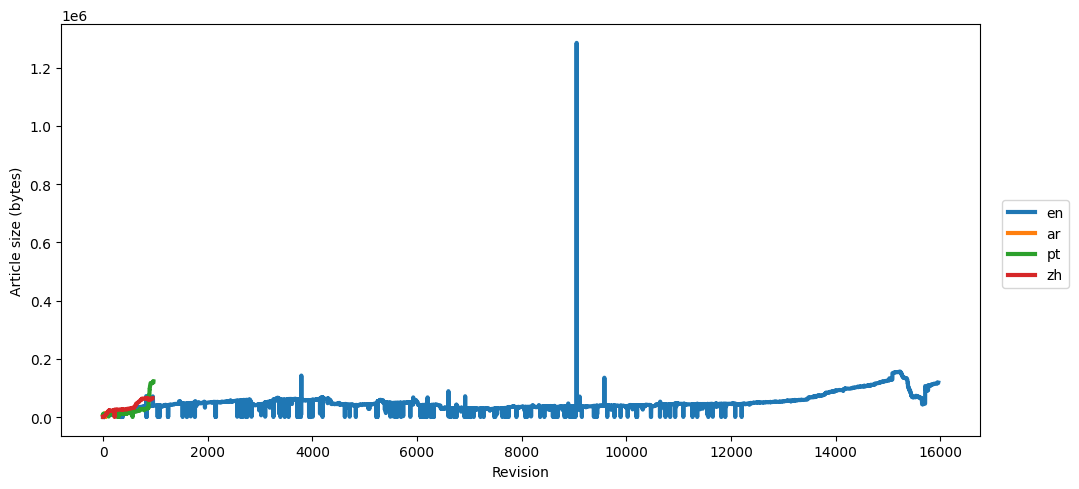

In [30]:
f,ax = plt.subplots(1,1,figsize=(10,5))

page1_en_rev_df['size'].plot(ax=ax,label='en',lw=3)
page1_ar_rev_df['size'].plot(ax=ax,label='ar',lw=3)
page1_pt_rev_df['size'].plot(ax=ax,label='pt',lw=3)
page1_zh_rev_df['size'].plot(ax=ax,label='zh',lw=3)

ax.set_xlabel('Revision')
ax.set_ylabel('Article size (bytes)')

f.legend(loc='center left',bbox_to_anchor=(1,.5))
f.tight_layout()

Again, plotting by revision index isn't helpful, so repeat the steps above to plot out the number of revisions by day.

In [31]:
# Group revisions by date and apply the agg_d
page1_en_agg_df = page1_en_rev_df.groupby('date').agg(agg_d)

# Clean up the agg_d to daily activity
page1_en_agg_df = daily_activity_maker(page1_en_agg_df)

# Repeat for the other pages
page1_ar_agg_df = page1_ar_rev_df.groupby('date').agg(agg_d)
page1_ar_agg_df = daily_activity_maker(page1_ar_agg_df)

page1_pt_agg_df = page1_pt_rev_df.groupby('date').agg(agg_d)
page1_pt_agg_df = daily_activity_maker(page1_pt_agg_df)

page1_zh_agg_df = page1_zh_rev_df.groupby('date').agg(agg_d)
page1_zh_agg_df = daily_activity_maker(page1_zh_agg_df)

# Inspect one
page1_en_agg_df.tail()

/tmp/ipykernel_153/136115070.py:2: FutureWarning: The provided callable <function median at 0x7f0ae43c2ca0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  page1_en_agg_df = page1_en_rev_df.groupby('date').agg(agg_d)
/tmp/ipykernel_153/2728528314.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg_df['size'].fillna(method='ffill',inplace=True)
/tmp/ipykernel_153/136115070.py:8: FutureWarning: The provided callable <function median at 0x7f0ae43c2ca0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  page1_ar_agg_df = page1_ar_rev_df.groupby('date').agg(agg_d)
/tmp/ipykernel_153/2728528314.py:13: FutureWarning: Series.fillna with 'method' is 

,size,editors,revisions
2025-04-15,118348.0,0.0,0.0
2025-04-16,118348.0,0.0,0.0
2025-04-17,118348.0,0.0,0.0
2025-04-18,118348.0,0.0,0.0
2025-04-19,118331.0,1.0,1.0


Plot the revisions for the different language editions, using a 28-day rolling average to smooth things out.

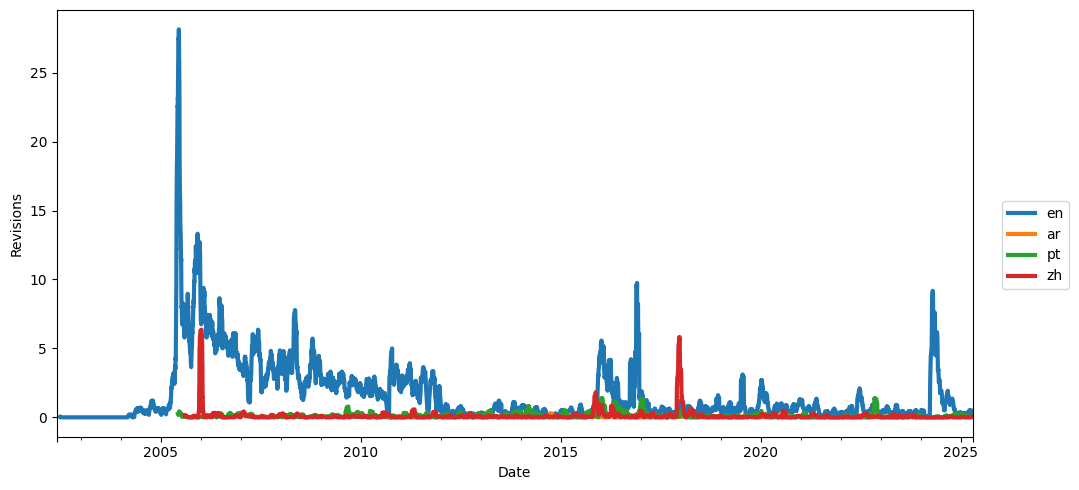

In [32]:
f,ax = plt.subplots(1,1,figsize=(10,5))

page1_en_agg_df['revisions'].rolling(28).mean().plot(ax=ax,label='en',lw=3)
page1_ar_agg_df['revisions'].rolling(28).mean().plot(ax=ax,label='ar',lw=3)
page1_pt_agg_df['revisions'].rolling(28).mean().plot(ax=ax,label='pt',lw=3)
page1_zh_agg_df['revisions'].rolling(28).mean().plot(ax=ax,label='zh',lw=3)

ax.set_xlabel('Date')
ax.set_ylabel('Revisions')

f.legend(loc='center left',bbox_to_anchor=(1,.5))
f.tight_layout()

## Comparing pageview dynamics

### Comparing languages

In [33]:
page1_en_pv = get_pageviews(page1_title,endpoint='en.wikipedia.org')
page1_ar_pv = get_pageviews(page1_title_ar,endpoint='ar.wikipedia.org')
page1_pt_pv = get_pageviews(page1_title_pt,endpoint='pt.wikipedia.org')
page1_zh_pv = get_pageviews(page1_title_zh,endpoint='zh.wikipedia.org')

page1_pv_df = pd.DataFrame({'en':page1_en_pv,'ar':page1_ar_pv,'pt':page1_pt_pv,'zh':page1_zh_pv})
page1_pv_df.head()

,en,ar,pt,zh
timestamp,,,,
2015-07-01,3489,4,415,217
2015-07-02,3561,2,422,244
2015-07-03,3381,9,417,267
2015-07-04,3782,6,392,238
2015-07-05,3874,6,421,254


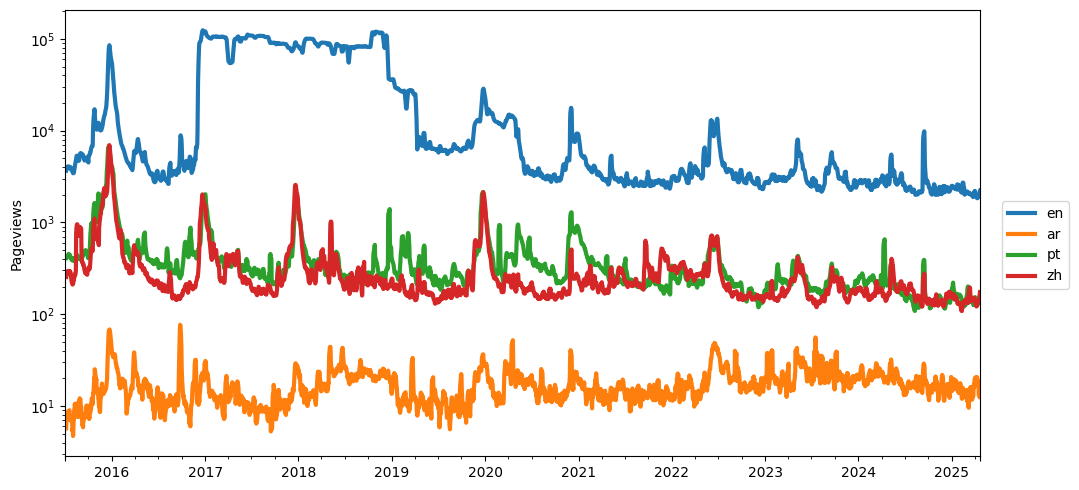

In [34]:
f,ax = plt.subplots(1,1,figsize=(10,5))

page1_pv_df.rolling(7).mean().plot(ax=ax,legend=False,lw=3)
f.legend(loc='center left',bbox_to_anchor=(1,.5))

ax.set_xlabel(None)
ax.set_ylabel('Pageviews')
ax.set_yscale('log')

f.tight_layout()

### Comparing articles

In [35]:
page1_en_pv = get_pageviews(page1_title,endpoint='en.wikipedia.org')
page2_en_pv = get_pageviews(page2_title,endpoint='en.wikipedia.org')

page1and2_pv_df = pd.DataFrame({'Darth Vader':page1_en_pv,'Luke Skywalker':page2_en_pv})
page1and2_pv_df.head()

,Darth Vader,Luke Skywalker
timestamp,,
2015-07-01,3489,297
2015-07-02,3561,317
2015-07-03,3381,291
2015-07-04,3782,310
2015-07-05,3874,354


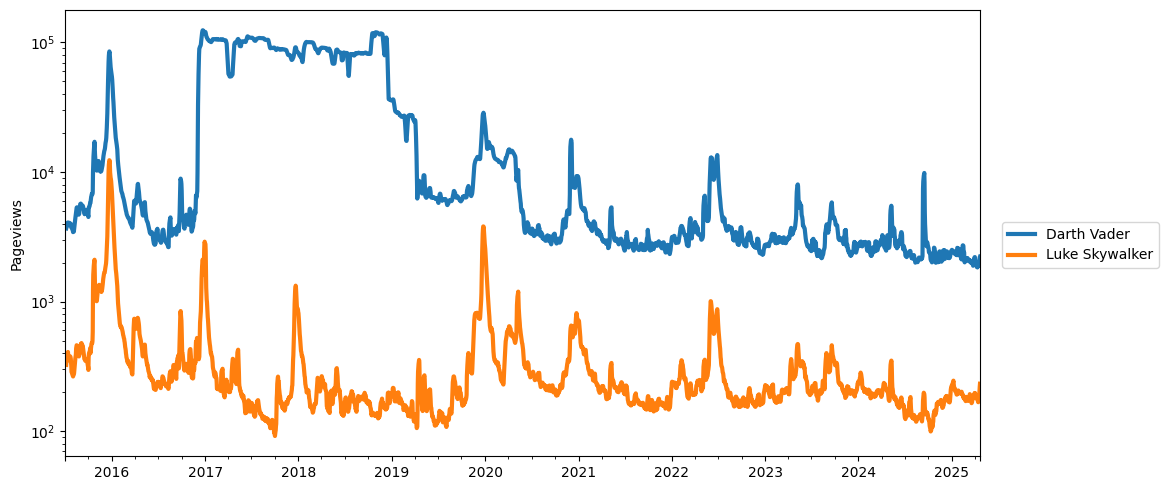

In [36]:
f,ax = plt.subplots(1,1,figsize=(10,5))

page1and2_pv_df.rolling(7).mean().plot(ax=ax,legend=False,lw=3)
f.legend(loc='center left',bbox_to_anchor=(1,.5))

ax.set_xlabel(None)
ax.set_ylabel('Pageviews')
ax.set_yscale('log')

f.tight_layout()

## Content dynamics

### Wiki-links over time

In [37]:
# Compute the year for each revision
page1_en_rev_df['year'] = page1_en_rev_df['date'].apply(lambda x:x.year)

# Get the first new revision of every year
page1_annual_revs = page1_en_rev_df.groupby('year')['revid'].min()

# Create a container to store the wiki-links for different years
page1_annual_wikilinks = {}

# Loop through each of these revisions and get the wikilinks on the page that year
for year,revid in page1_annual_revs.to_dict().items():
    page1_annual_wikilinks[year] = get_revision_outlinks(revid, endpoint='en.wikipedia.org/w/api.php')

TypeError: 'NoneType' object is not subscriptable

Plot out the number of links on the page each year.

In [ ]:
page1_annual_wikilinks_counts = pd.Series({year:len(linklist) for year,linklist in page1_annual_wikilinks.items()})

ax = page1_annual_wikilinks_counts.plot(kind='bar',color='grey')
ax.set_ylabel('Link count')

Analyze which links appeared in which years.

In [ ]:
# Create a container to store a list of all the links from each year
page1_all_wikilinks = []

for linklist in list(page1_annual_wikilinks.values()):
    for link in linklist:
        page1_all_wikilinks.append(link)
        
# Remove duplicate links
page1_all_wikilinks = list(set(page1_all_wikilinks))

# Create a container to store whether a link appeared in a given year
page1_annual_wikilinks_present = {}

# Loop through each year's wikilinks
for year,linklist in page1_annual_wikilinks.items():
    # Create a nested dictionary keyed by the year
    page1_annual_wikilinks_present[year] = {}
    # Loop through all of the possible wikilinks across years
    for link in page1_all_wikilinks:
        # Check if the link is present that year
        if link in linklist:
            page1_annual_wikilinks_present[year][link] = 1
        else:
            page1_annual_wikilinks_present[year][link] = 0
            
# Convert to a DataFrame
page1_annual_wikilinks_present_df = pd.DataFrame(page1_annual_wikilinks_present)

# Reindex so the DataFrame is sorted by the number of appearances
_ix = page1_annual_wikilinks_present_df.sum(1).sort_values(ascending=False).index
page1_annual_wikilinks_present_df = page1_annual_wikilinks_present_df.loc[_ix]

# Inspect
page1_annual_wikilinks_present_df.head(10)

Visualize every 10th link for whether it was present in the article in a given year.

In [ ]:
f,ax = plt.subplots(1,1,figsize=(5,20))

sb.heatmap(page1_annual_wikilinks_present_df[::10],ax=ax,cbar=False,square=True)

### Content over time

This is going to require some NLTK functions, which may require you to download external packages. If you get errors here, Google for how to fix them before contacting me.

In [ ]:
# Create a container to store the content for different years
page1_annual_content = {}

# Loop through each of these revisions and get the content on the page that year
for year,revid in page1_annual_revs.to_dict().items():
    page1_annual_content[year] = get_revision_content(revid, endpoint='en.wikipedia.org/w/api.php')

In [ ]:
# Import a tokenizer to break the content up into words
from nltk.tokenize import word_tokenize

# Count the number of words per year
page1_annual_word_counts = {year:len(word_tokenize(content)) for year,content in page1_annual_content.items()}

# Convert to a Series and plot
ax = pd.Series(page1_annual_word_counts).plot(kind='bar',color='grey')
ax.set_ylabel('Word count')

In [ ]:
# Import the VADER sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Import a sentence tokenizer
from nltk.tokenize import sent_tokenize

# Instantiate the model
sia = SentimentIntensityAnalyzer()

# Create a container to store the annual sentiment scores
page1_annual_sentiment = {}

# Loop through each year's content
for year, content in page1_annual_content.items():
    annual_score = 0
    # Break the content up into sentences
    sentences = sent_tokenize(content)
    
    # For each sentiment, analyze the polarity
    for sentence in sentences:
        sentence_score = sia.polarity_scores(sentence)['compound']
        
        # Add the polarities each sentence back into the total
        annual_score += sentence_score
    
    # Normalize the score by the the number of sentences and save to the container
    page1_annual_sentiment[year] = annual_score/len(sentences)
    
# Visualize the sentiment score of the article each year
ax = pd.Series(page1_annual_sentiment).plot(kind='bar',color='grey')
ax.set_ylabel('Sentiment')


### External links over time

In [ ]:
# Create a container to store the external links for different years
page1_annual_externallinks = {}

# Loop through each of these revisions and get the external links on the page that year
for year,revid in page1_annual_revs.to_dict().items():
    page1_annual_externallinks[year] = get_revision_externallinks(revid, endpoint='en.wikipedia.org/w/api.php')

The external links have common domains.

In [38]:
page1_annual_externallinks[2025][:5]

NameError: name 'page1_annual_externallinks' is not defined

I'll adapt this [StackOverflow answer](https://stackoverflow.com/questions/9626535/get-protocol-host-name-from-url) to pull out the domains.

In [57]:
from urllib.parse import urlparse

parsed_uri = urlparse('http://www.starwars.com/databank/shmi-skywalker-lars')
'{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)

'http://www.starwars.com/'

In [58]:
# For counting the number of values in a list
from collections import Counter

# Create a container to store the domains for each external link
page1_annual_domains = {}

for year, linklist in page1_annual_externallinks.items():
    # Create a container to store the domains for each year
    domain_list = []
    for link in linklist:
        parsed_uri = urlparse(link)
        domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
        domain_list.append(domain)
        
    page1_annual_domains[year] = Counter(domain_list)
    
# Inspect 2006
page1_annual_domains[2006]

Counter({'http://theforce.net/': 3,
         'http://www.starwars.com/': 3,
         'http://www.theforce.net/': 2,
         'http://www.imsdb.com/': 2,
         'http://starwars.wikicities.com/': 2,
         'http://blogs.starwars.com/': 1,
         'http://www.imdb.com/': 1,
         'http://www.cathedral.org/': 1,
         'http://www.afi.com/': 1})

Visualize how many unique domains are used every year.

Text(0, 0.5, 'Domain count')

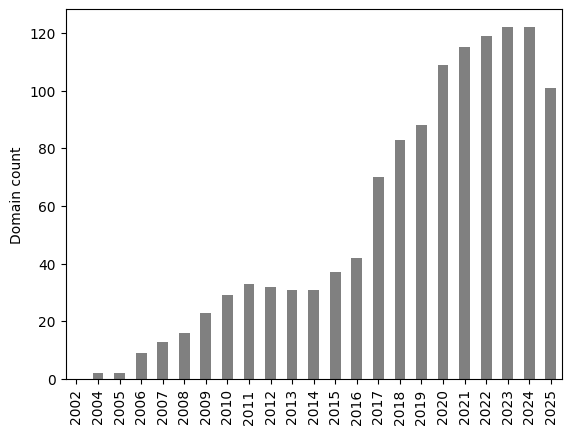

In [59]:
# Count the number of unique domains per year
page1_annual_domain_counts = {year:len(domain_counts) for year,domain_counts in page1_annual_domains.items()}

# Convert to a Series and plot
ax = pd.Series(page1_annual_domain_counts).plot(kind='bar',color='grey')
ax.set_ylabel('Domain count')

In the wikilinks by year, we wrote a loop to get whether a link occurred in a given year. We can also just read the dictionary of dictionaries into a DataFrame using the `.from_dict()` method.

In [60]:
page1_annual_domains_df = pd.DataFrame.from_dict(page1_annual_domains)
page1_annual_domains_df.fillna(0,inplace=True)

# Reindex so the DataFrame is sorted by the number of appearances
_ix = page1_annual_domains_df.sum(1).sort_values(ascending=False).index
page1_annual_domains_df = page1_annual_domains_df.loc[_ix]

# Inspect
page1_annual_domains_df.head()

,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
https://web.archive.org/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,20.0,23.0,27.0,25.0,26.0,30.0,142.0,126.0
https://www.starwars.com/,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,5.0,8.0,23.0,22.0,23.0,24.0
http://www.starwars.com/,0.0,0.0,1.0,3.0,3.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,7.0,7.0,14.0,15.0,15.0,15.0,15.0,0.0,0.0,0.0,0.0
https://ign.com/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,5.0,5.0,5.0,5.0
http://www.ign.com/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,5.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0


Visualize the frequency of the top 50 domains over time.

<Axes: >

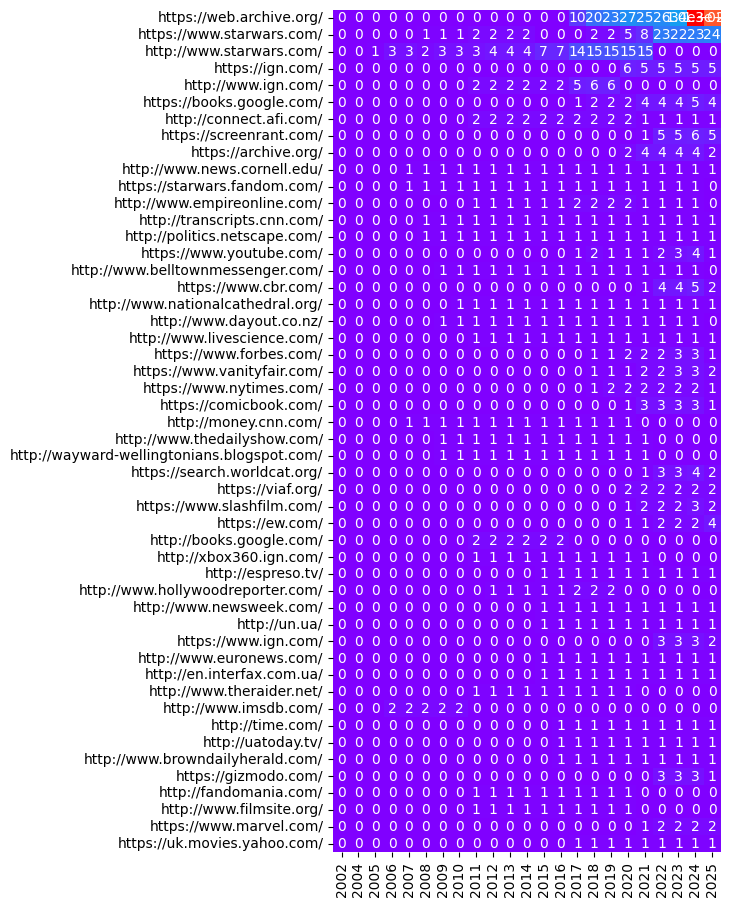

In [61]:
f,ax = plt.subplots(1,1,figsize=(5,20))

sb.heatmap(page1_annual_domains_df[:50],ax=ax,cbar=False,square=True,cmap='rainbow',annot=True)

## Structural patterns

### Hyperlink network

Create a hyperlink network of the links from a page and how those neighboring pages link to each other. This step could take 3-5 (or more) minutes depending on the number of links.

In [62]:
# Create an empty container to store the neighbors links
neighbor_outlinks = {}

# Get all the links on a page and store in the neighbor_outlinks
neighbor_outlinks[page1_title] = get_page_outlinks(page1_title,endpoint='en.wikipedia.org/w/api.php')

# For each link from a page, get its links and store in neighbor_outlinks
for neighbor in set(neighbor_outlinks[page1_title]):
    try:
        neighbor_outlinks[neighbor] = get_page_outlinks(neighbor)
    except KeyboardInterrupt:
        # Interrupt if I tell the process to interrupt
        break
    except:
        print("Error on '{0}'".format(neighbor))
        pass


TypeError: 'NoneType' object is not subscriptable

Now turn the `neighbor_outlinks` data into a network.

In [157]:
# Create an empty networkx graph object
wikilink_g = nx.DiGraph()

# Loop through the dictionary of links
for page,linklist in neighbor_outlinks.items():
    for link in linklist:
        # Only include the original page's neighbors and exclude the central page
        if link in neighbor_outlinks[page1_title] and link != page1_title and page != page1_title:
            # If the graph already has this edge, increase its weight
            if wikilink_g.has_edge(page,link):
                wikilink_g[page][link]['weight'] += 1
            # Otherwise add the edge with its weight set to 1
            else:
                wikilink_g.add_edge(page,link,weight=1)

# Report out the size of the network
print("There are {0:,} nodes and {1:,} links in the network.".format(wikilink_g.number_of_nodes(), wikilink_g.number_of_edges()))

# Write the network to disk
nx.write_gexf(wikilink_g,'wikilink_{0}.gexf'.format(page1_title))


There are 244 nodes and 2,824 links in the network.


You'll probably want to use [Gephi](http://www.gephi.org) to visualize the hyperlink network, but we can force Matplotlib to do it for us.

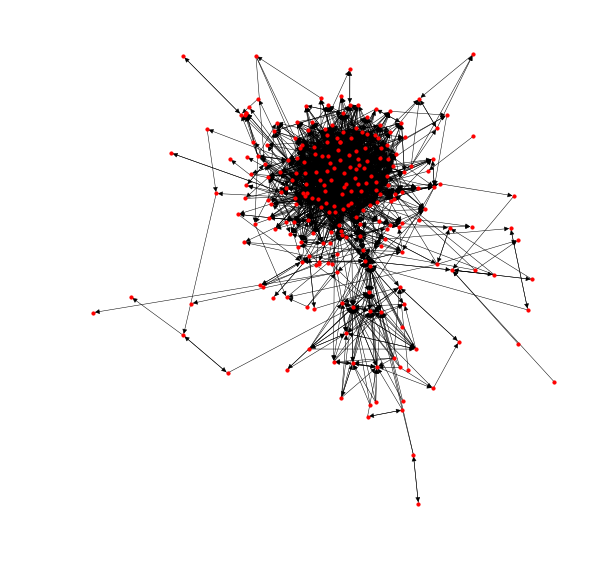

In [158]:
# Plot the nodes using a spring embedding algorithm
pos = nx.kamada_kawai_layout(wikilink_g)

# Make an empty canvas
f,ax = plt.subplots(1,1,figsize=(10,10))

# Draw the graph
nx.draw(G = wikilink_g,
        pos = pos,
        with_labels = False,
        node_size = 10,
        width = .5,
        ax=ax
       )

### Coauthorship network

Using all of the pages an article links to, explore how these articles also share editors in common. This information retrieval could take more than 5 minutes if you're retrieving the revision histories of hundreds of articles with thousands of revisions.

In [ ]:
# Create an empty container to store the neighbors revisions
neighbor_revisions = {}

# Add the revisions for the seed page
neighbor_revisions[page1_title] = get_page_revisions(page1_title)

# For each neighboring article in the hyperlink network
for neighbor in set(neighbor_outlinks[page_title]):
    try:
        # Get the page revisions and add them into the neighbor_revisions
        neighbor_revisions[neighbor] = get_page_revisions(neighbor)
    except KeyboardInterrupt:
        # Interrupt if it tell the process to interrupt
        break
    except:
        # If there's an error, print and skip
        print("Error on '{0}'".format(neighbor))
        pass
    


Combine all the data together and make a coauthorship network.

In [ ]:
# Combine all the neighbor revisions into a big DataFrame
neighbor_rev_df = pd.concat(neighbor_revisions,sort=False)
neighbor_rev_df.reset_index(drop=True,inplace=True)

# Add a year column
neighbor_rev_df['year'] = neighbor_rev_df['date'].apply(lambda x:x.year)

# Save to disk since it took a while to get
neighbor_rev_df.to_csv("revisions_{0}.csv".format(page1_title,index=False,encoding='utf8'))

# Groupby-aggregate the results by page, user, and year         
agg_d = {'revid':len}
coauth_el = neighbor_rev_df.groupby(['page','user','year']).agg(agg_d)

# Unstack the year column, fill the missing values with zeroes, and make the index into columns
coauth_el = coauth_el.unstack(2).fillna(0).reset_index()

# Fix up the column names
coauth_el.columns = coauth_el.columns.droplevel(0)
str_years = [str(i) for i in range(2001,2019)]
coauth_el.columns = ['page','user'] + str_years
coauth_el['all_years'] = coauth_el[str_years].sum(1)

# There are some instances of users and pages having the same name, drop these outliers
bad_rows = coauth_el[coauth_el['page'] == coauth_el['user']].index
coauth_el = coauth_el.drop(bad_rows)

# Make the graph
coauth_g = nx.from_pandas_edgelist(coauth_el,source='user',target='page',edge_attr=True)
print("There are {0:,} nodes and {1:,} links in the network.".format(coauth_g.number_of_nodes(), coauth_g.number_of_edges()))

# Define the pages and users
coauth_pages = coauth_el['page'].unique()
coauth_users = coauth_el['user'].unique()

# Give the users and pages attributes for visualization purposes
for page in coauth_pages:
    coauth_g.node[page]['type'] = 'page'
    
for page in coauth_users:
    coauth_g.node[page]['type'] = 'user'

# Write to disk
#nx.write_gexf(coauth_g,'{0}.gexf'.format(page1_title))


In [ ]:
# Make the gr
final_g = nx.from_pandas_edgelist(coauth_el,source='user',target='page',edge_attr=['all_years'])

annual_g = {}

for year in str_years:
    _df = coauth_el[coauth_el[year] > 10]
    _users = _df['user'].unique()
    _pages = _df['page'].unique()
    _g = nx.from_pandas_edgelist(_df,source='user',target='page',edge_attr=[year])
    annual_g[year] = nx.bipartite.weighted_projected_graph(_g,_pages)
    


### Activity correlation network

In [159]:
# Create an empty container to store the neighbors pageviews
neighbor_pageviews = {}

# Add the revisions for the seed page
neighbor_pageviews[page1_title] = get_pageviews(page1_title)

# For each neighboring article in the hyperlink network
for neighbor in set(neighbor_outlinks[page1_title]):
    try:
        # Get the pageviews and add them into the neighbor_revisions
        neighbor_pageviews[neighbor] = get_pageviews(neighbor)
    except KeyboardInterrupt:
        # Interrupt if it tell the process to interrupt
        break
    except:
        # If there's an error, print and skip
        print("Error on '{0}'".format(neighbor))
        pass

In [165]:
# Convert the dictionary to a DataFrame
neighbor_pageview_df = pd.DataFrame(neighbor_pageviews)

# Get the correlations between timeseries and unstack into an edgelist
neighbor_pageview_corr_df = neighbor_pageview_df.corr().unstack().sort_values().reset_index()

# Rename columns
neighbor_pageview_corr_df.columns = ['page 1','page 2','corr']

# Drop instances of the page being correlated with itself
neighbor_pageview_corr_df = neighbor_pageview_corr_df[neighbor_pageview_corr_df['page 1'] != neighbor_pageview_corr_df['page 2']] 

# Inspect
neighbor_pageview_corr_df.tail()

,page 1,page 2,corr
64765,Palpatine,Count Dooku,0.988538
64766,Star Wars expanded universe,List of Star Wars books,0.989092
64767,List of Star Wars books,Star Wars expanded universe,0.989092
64768,Count Dooku,General Grievous,0.989673
64769,General Grievous,Count Dooku,0.989673


Show examples of two time series that are highly correlated and highly anti-correlated.

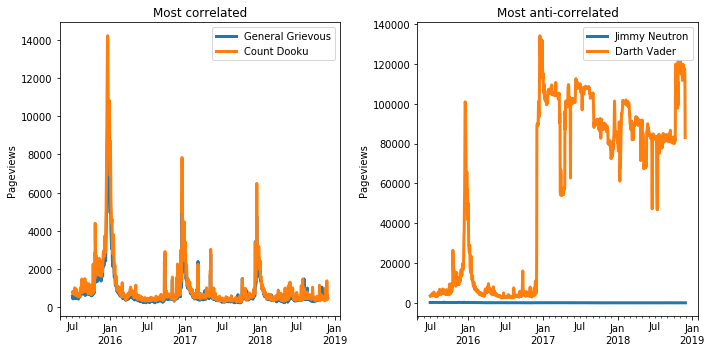

In [184]:
# Get the most correlated and anticorrelated pages
most_correlated_pages = neighbor_pageview_corr_df.tail(1)[['page 1','page 2']].values
most_anticorrelated_pages = neighbor_pageview_corr_df.head(1)[['page 1','page 2']].values

# Make two side-by-side plots
f,axs = plt.subplots(1,2,figsize=(10,5))

neighbor_pageview_df[most_correlated_pages.tolist()[0]].plot(ax=axs[0],legend=False,lw=3)
neighbor_pageview_df[most_anticorrelated_pages.tolist()[0]].plot(ax=axs[1],legend=False,lw=3)

axs[0].legend()
axs[1].legend()

axs[0].set_title('Most correlated')
axs[1].set_title('Most anti-correlated')

for ax in axs:
    ax.set_xlabel(None)
    ax.set_ylabel('Pageviews')

f.tight_layout()


The intuition behind an activity correlation network is pages that have more similar pageview activity have stronger connections than pages with anti-correlated or uncorrelated pageview activity. The articles on the left figure should be connected and the articles on the right figure should be unconnected.

There are 161 nodes and 5,519 links in the network.


/Users/briankeegan/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


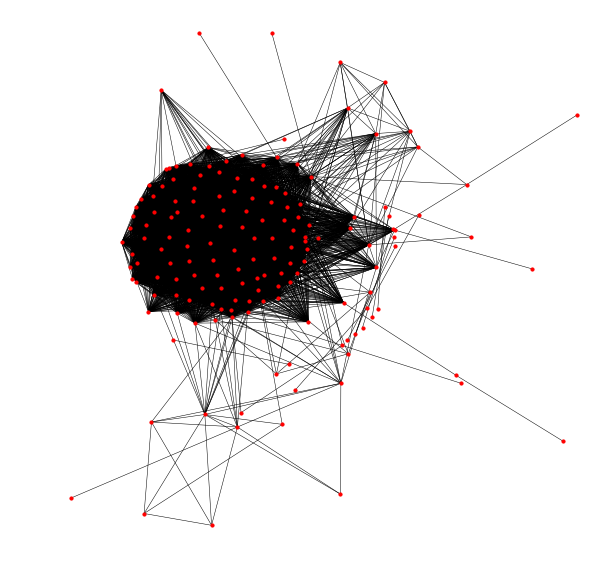

In [191]:
# Throw away article links unless they have a correlation of 0.5
corr_el = neighbor_pageview_corr_df[neighbor_pageview_corr_df['corr'] > .5]

activity_corr_g = nx.from_pandas_edgelist(corr_el,source='page 1',target='page 2',edge_attr=True,create_using=nx.Graph)
print("There are {0:,} nodes and {1:,} links in the network.".format(activity_corr_g.number_of_nodes(), activity_corr_g.number_of_edges()))

# Write the network to disk
nx.write_gexf(activity_corr_g,'activity_{0}.gexf'.format(page1_title))

# Plot the nodes using a spring embedding algorithm
pos = nx.kamada_kawai_layout(activity_corr_g)

# Make an empty canvas
f,ax = plt.subplots(1,1,figsize=(10,10))

# Draw the graph
nx.draw(G = activity_corr_g,
        pos = pos,
        with_labels = False,
        node_size = 10,
        width = .5,
        ax=ax
       )